**Import Required Libraries**

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

**Data Preprocession (Download and Transformation)**

In [2]:
#Download Dataset

database_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(database_url, '.')

#Extract files from Archieve

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

#Check the directory and Classes

data_dir = './data/cifar10'
print('Directory Contains: ', os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print('Classes: ', classes)

  0%|          | 0/135107811 [00:00<?, ?it/s]

Directory Contains:  ['test', 'train']
Classes:  ['cat', 'dog', 'truck', 'automobile', 'ship', 'airplane', 'deer', 'horse', 'bird', 'frog']


In [3]:
#Data Transformation (Normalization and Augmentation)

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))      #stats = ((Mean), (STD))

train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode= 'reflect'),
                         tt.RandomHorizontalFlip(),
                         #tt.RandomRotation(),
                         #tt.RandomResizedCrop(256, scale= (0.5, 0.9), ratio = (1, 1)),
                         #tt.ColorJitter(brightness= 0.1, contrast= 0.1, saturation= 0.1, hue= 0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace= True)])

valid_tfms = tt.Compose([tt.ToTensor(), 
                         tt.Normalize(*stats)])

In [4]:
#Pytorch Dataset (Image to Data)

train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [5]:
#Define Batch Size

batch_size = 200

In [6]:
#Pytorch Data Loader (Load the Data)

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle = True,
                      num_workers = 2,
                      pin_memory = True)

valid_dl = DataLoader(valid_ds,
                      batch_size *2,
                      num_workers = 2,
                      pin_memory = True)

In [7]:
#Denormalization to show batch

def denormalization(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

#Show a sample batch of images

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalization(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow= 8).permute(1, 2, 0).clamp(0, 1))
    break

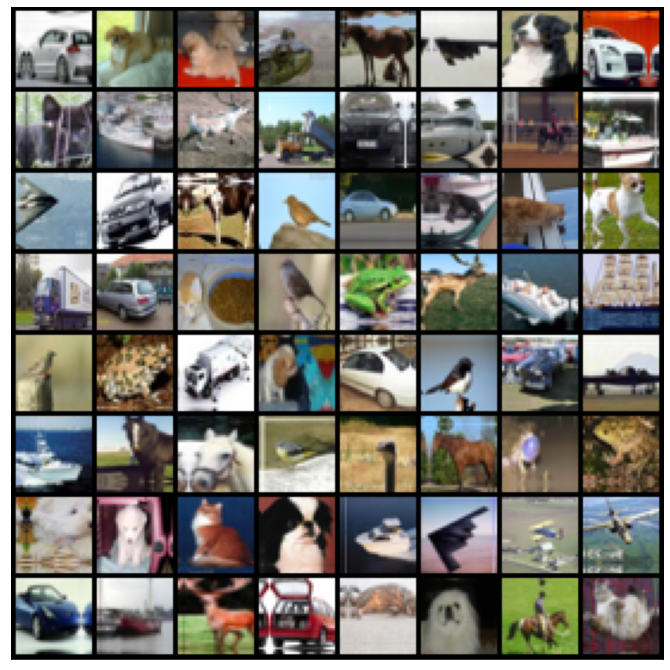

In [8]:
show_batch(train_dl)

**Graphics Processing Unit (GPU)**

In [9]:
#Primary Operations (GPU Setup)

def get_default_device():
  """If GPU is available use Cuda, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move Tensors to Chosen Device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a DataLoader to move data to device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of Batched"""
    return len(self.dl)

In [10]:
#Save device type

device = get_default_device()
device

device(type='cuda')

In [11]:
#Load the data to the device

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

**Basic Image Classification Model**

In [20]:
#Define accuracy

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#Image Classification Base

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Prediction
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Predictions
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    acc = accuracy(out, labels)               #Calculate Accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     #Mean of Loss in a epoch
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        #Mean of Accuracy in a epoch
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} 

  def epoch_end(self, epoch, result):
    print("Epoch: [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

**Residual Model (ResNet9)**

In [13]:
#Define Convolutional Block

def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding= 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace= True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

#ResNet9 Model

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    #Input: 3 X 32 X 32
    self.conv1 = conv_block(in_channels, 64)                 #Output: 64 X 32 X 32
    self.conv2 = conv_block(64, 128, pool = True)            #Output: 128 X 16 X 16
    self.res1 = nn.Sequential(conv_block(128, 128),
                              conv_block(128, 128))          #Output: 128 X 16 X 16

    self.conv3 = conv_block(128, 256, pool = True)           #Output: 256 X 8 X 8
    self.conv4 = conv_block(256, 512, pool = True)           #Output: 512 X 4 X 4
    self.res2 = nn.Sequential(conv_block(512, 512),
                              conv_block(512, 512))          #output: 512 X 4 X 4
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4),         #Output: 512 X 1 X 1
                                    nn.Flatten(),            #Output: 512
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))  #Output: 10

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)
    return out

In [14]:
#Load Model to the device

model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

**Model Training**

In [15]:
@torch.no_grad()

#Defince Evaluation Function

def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

#Record the learning rates

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

#Fit the model with Fit One Cycle Method

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0,
                  grad_clip = None, opt_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  #Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

  #Set up one cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs,
                                              steps_per_epoch = len(train_loader))
  
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      #Record and Update Learning Rate
      lrs.append(get_lr(optimizer))
      sched.step()

    #Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [16]:
#Evaluation without Training

history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.09390000253915787, 'val_loss': 2.3069489002227783}]

In [17]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [21]:
#Training the model with 10 epochs
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                      grad_clip= grad_clip,
                      weight_decay = weight_decay, 
                      opt_func = opt_func)

CPU times: user 7min 57s, sys: 6min 58s, total: 14min 55s
Wall time: 15min 29s


**Visualize Training Progress (Plot)**

In [22]:
#Accuracy Vs Epoch

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy Vs No. of Epoch')

#Loss Vs Epoch

def plot_losses(hist):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss Vs No. of Epoch');

#Learning Rate Vs Batch No

def plot_lrs(hist):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning rate vs Batch no.')

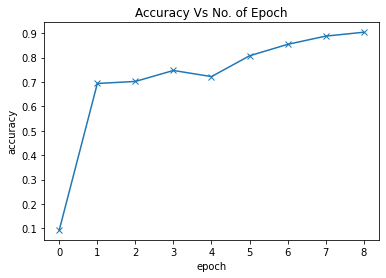

In [24]:
plot_accuracies(history)

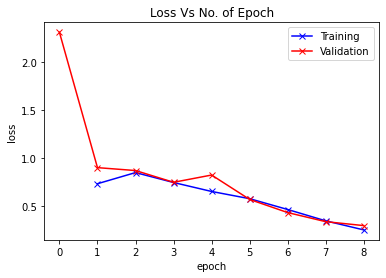

In [25]:
plot_losses(history)

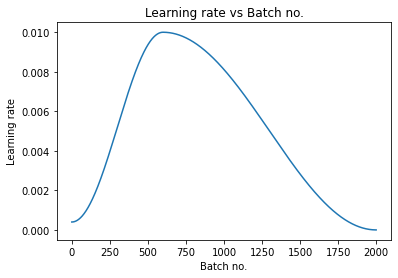

In [27]:
plot_lrs(history)

**Testing with Individual Images**

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: automobile , Predicted: automobile


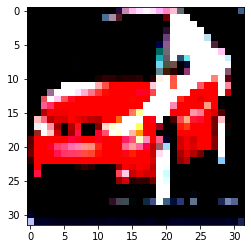

In [30]:
img, label = valid_ds[1364]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

**Testing**

In [31]:
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size *2), device)
result = evaluate(model, test_loader)
print("Test Accuracy: ", result['val_acc'], ", Test Loss: ", result['val_loss'])

Test Accuracy:  0.9036999344825745 , Test Loss:  0.2922283113002777


**Saving the Model**

In [32]:
torch.save(model.state_dict(), 'cifar-10-ResNet.pth')

**Using saved model**

In [33]:
model2 = to_device(ResNet9(3, 10), device)
model2.load_state_dict(torch.load('cifar-10-ResNet.pth'))

<All keys matched successfully>

In [34]:
evaluate(model2, test_loader)

{'val_acc': 0.9036999344825745, 'val_loss': 0.2922283113002777}